#### Problem statement

#### Data description

In [2]:
#preprocessing libraries
import numpy as np
import pandas as pd

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#modelling and metrics libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import mlflow
import mlflow.sklearn

from tqdm import tqdm
import io

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
#read the dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

train_orig = train.copy()
test_orig = test.copy()
submission_orig = submission.copy()

In [4]:
train.shape, test.shape, submission.shape

((6368, 15), (3430, 14), (5, 2))

In [5]:
train.index, test.index, submission.index

(RangeIndex(start=0, stop=6368, step=1),
 RangeIndex(start=0, stop=3430, step=1),
 RangeIndex(start=0, stop=5, step=1))

In [20]:
train.columns, test.columns, submission.columns

(Index(['Product_id', 'Stall_no', 'instock_date', 'Market_Category',
        'Customer_name', 'Loyalty_customer', 'Product_Category', 'Grade',
        'Demand', 'Discount_avail', 'charges_1', 'charges_2 (%)',
        'Minimum_price', 'Maximum_price', 'Selling_Price'],
       dtype='object'),
 Index(['Product_id', 'Stall_no', 'instock_date', 'Market_Category',
        'Customer_name', 'Loyalty_customer', 'Product_Category', 'Grade',
        'Demand', 'Discount_avail', 'charges_1', 'charges_2 (%)',
        'Minimum_price', 'Maximum_price'],
       dtype='object'),
 Index(['Product_id', 'Selling_Price'], dtype='object'))

In [6]:
train.columns.difference(test.columns), train.columns.intersection(submission.columns)

(Index(['Selling_Price'], dtype='object'),
 Index(['Product_id', 'Selling_Price'], dtype='object'))

In [7]:
tgt_var = train.columns.difference(test.columns).values[0]
tgt_var

'Selling_Price'

###### Defining functions

In [8]:
def combinfo(data) :
    combi = pd.DataFrame(data.nunique(),columns=['Nunique()'])
    combi2 = pd.DataFrame(data.isna().sum(),columns=['isna() count'])
    combi3 = pd.concat([combi, combi2],axis=1)

    #import io
    buffer = io.StringIO()
    data.info(buf=buffer, memory_usage=False)
    s = buffer.getvalue()
    df = pd.DataFrame(s.split("\n"),columns=['info'])
    df_info = df.loc[5:len(data.columns)+5-1,'info'].str.split(n=4,expand=True).reset_index(drop=True)
    df_info.drop(columns=[0,3],axis=1,inplace=True)
    df_info.columns = ['Column','Non-Null count','Dtype']
    df_info.set_index('Column',inplace=True)

    combi5 = pd.concat([combi3, df_info],axis=1)
    return combi5

In [115]:
def print_score(model,y_act,y_pred,label,genre,display,logging,model_num,n_alpha,l1_ratio, n_knn) :  
    experiment_id = mlflow.set_experiment("he_halloweenSellPrice_training_exp") if logging == True else ""
    mlflow.start_run(experiment_id=experiment_id) if logging == True else ""
    
    if genre == "classification" :
        acc_scr =  accuracy_score(y_act,y_pred)
        rec_scr =  recall_score(y_act,y_pred)
        pre_scr =  precision_score(y_act,y_pred)
        f1_scr  =  f1_score(y_act,y_pred)
        rcac_scr = roc_auc_score(y_act,y_pred)
        conf_mat = confusion_matrix(y_act,y_pred)
        
        if display == True :
            print("Model :",model)
            print(label, "Accuracy  score :", acc_scr)
            print(label, "Recall    score :", rec_scr)
            print(label, "Precision score :", pre_scr)
            print(label, "F1        score :", f1_scr)
            print(label, "ROC_AUC   score :", rcac_scr)
            print(label, "Confusion Matrix:\n", conf_mat)
            print(label, "Classification Report\n", classification_report(y_act,y_pred))    
 
        if logging == True :
            mlflow.log_metric("Accuracy", acc_scr)
            mlflow.log_metric("Recall", rec_scr)
            mlflow.log_metric("Precision", pre_scr)
            mlflow.log_metric("F1", f1_scr)
            mlflow.log_metric("ROC_AUC", rcac_scr)
            mlflow.log_metric("Conf.Mat", conf_mat)
        
    elif genre == "regression" :
        mse_scr  = mean_squared_error(y_act, y_pred)
        rmse_scr = mean_squared_error(y_act, y_pred,squared=False)
        mae_scr  = mean_absolute_error(y_act,y_pred)
        rmsle_scr= np.log(np.sqrt(mean_squared_error(y_act,y_pred)))
        
        print(model,type(model))
        print(str(model).split('(')[0])
        if ("Lasso" not in str(model).split('(')[0] and "ElasticNet" not in str(model).split('(')[0]) : 
            mape_scr = np.mean(np.abs((np.array(y_act) - np.array(y_pred)) / np.array(y_act))) * 100
            r2_scr   = r2_score(y_act,y_pred)
            #print("y_pred",y_pred,np.log10(y_pred +1))
            #print("y_act",y_act,np.log10(y_act +1))
            print("mean",(np.log10(y_pred +1) - np.log10(y_act +1)).mean())
            other_scr= 0#round(np.sqrt(np.mean(np.square(np.log10(y_pred +1) - np.log10(y_act +1)))),3)
            print("os2:",other_scr)
        
        if display == True :     
            print("Model :",model)
            print(label, "MSE  score :", mse_scr)
            print(label, "RMSE score :", rmse_scr)
            print(label, "MAE  score :", mae_scr)
            print(label, "RMSLE score :", rmsle_scr)
            print(str(model).split('(')[0])
            if ("Lasso" not in str(model).split('(')[0] and "ElasticNet" not in str(model).split('(')[0]) : 
                print(label, "MAPE score :", mape_scr)
                print(label, "R2   score :", r2_scr)
                print(label, "Other score:", other_scr)

        if logging == True :
            mlflow.log_metric("RMSE", rmse_scr)     
            mlflow.log_metric("RMSLE", rmsle_scr)     
            if ("Lasso" not in str(model).split('(')[0] and "ElasticNet" not in str(model).split('(')[0]) : 
                mlflow.log_metric("R2", r2_scr)
                print("os3:",other_scr)
                mlflow.log_metric("Other", other_scr)

    if logging == True :
        mlflow.log_metric("model_no",model_num) 
        mlflow.log_metric("alpha",n_alpha) 
        mlflow.log_metric("l1_ratio",l1_ratio)
        mlflow.log_metric("n_knn",n_knn)
        mlflow.sklearn.log_model(model, "Model")      
    mlflow.end_run() if logging == True else ""

In [10]:
def build_model(model,X,y,label,genre,display,logging,model_num,n_alpha,l1_ratio, n_knn):
    model.fit(X,y)
    y_train_pred = model.predict(X)
    #pd.Series(data=model.coef_[0],index=X.columns).plot(kind='bar')  
    print_score(model,y,y_train_pred,label,genre,display,logging,model_num,n_alpha,l1_ratio, n_knn)
    return y_train_pred

In [11]:
def univar_plot() :
    %matplotlib inline
    plt.figure(figsize=(16,30))
    k=1
    col_cnt = 3
    row_cnt = int(np.ceil(len(data.columns)/3))
    for col in data.columns:
        plt.subplot(row_cnt,col_cnt,k)
        if data[col].nunique()<25: 
            title='bar'
            data[col].value_counts().plot(kind ='bar')
        else: 
            title='hist'
            data[col].value_counts().plot(kind ='hist')
        #plt.title(title+'_'+col)
        plt.ylabel(title+'_'+col)    
        k+=1
    plt.show()

In [12]:
def bivar_plot_reg_all_dim() :
    %matplotlib inline
    j=k=0
    col_cnt = 3
    j=[idx for idx, col in enumerate(data.drop(columns=['User_ID','Product_ID','Purchase','source']).columns) if(data[col].nunique()<25) ]
    j=len(j)
    row_cnt = int(np.ceil(j/3))
    row_cnt+=1

    fig, ax = plt.subplots(ncols=col_cnt, nrows=row_cnt, figsize=(16, row_cnt*6))
    ax = ax.flatten()
    tgt_var = train.columns.difference(test.columns).values[0]

    plot_kind = 'bar' if data[tgt_var].nunique()<5 else 'hist'

    for idx, col in enumerate(data.drop(columns=['User_ID','Product_ID','Purchase','source']).columns) : 
        if data[col].nunique()<25 and data[tgt_var].nunique() <5:
            cross = pd.crosstab(data[tgt_var],data[col])      
            #display(cross)
            #display(cross.div(cross.sum(1), axis=0))
            cross.div(cross.sum(1), axis=0).plot(kind=plot_kind, stacked=True, ax=ax[k])
            #plt.title(col)  
        else :
            plt.subplot(row_cnt,col_cnt,k+1)
            if data[tgt_var].nunique() < 5 :
                plt.scatter(x=data[col], y=data[tgt_var].notnull())
            else :
                plt.scatter(y=data[col].notnull(), x=data[tgt_var]) 
            plt.xlabel(col) 
        k+=1        
    plt.show() 

In [58]:
def bivar_plot_reg_all_dim_snsbar() :
    %matplotlib inline
    j=k=0
    col_cnt = 3
    j=[idx for idx, col in enumerate(data.drop(columns=['Product_id','Selling_Price','source']).columns) if(data[col].nunique()<25) ]
    j=len(j)
    row_cnt = int(np.ceil(j/3))
    row_cnt+=1 if row_cnt%3!=0 else row_cnt

    fig, ax = plt.subplots(ncols=col_cnt, nrows=row_cnt, figsize=(16, row_cnt*6))
    ax = ax.flatten()
    tgt_var = train.columns.difference(test.columns).values[0]
    tgt_var
    for idx, col in enumerate(data.drop(columns=['Product_id','Selling_Price','source']).columns) : 
        if(data[col].nunique()<25) :
            sns.barplot(x = data[col], y =data[tgt_var], data = data, palette ='plasma',ax=ax[k])
            plt.xlabel(col) 
        k+=1        
    plt.show() 

In [13]:
def null_percent(data) :
    print("for all features")
    [print(data[i].isna().sum(),"(",round((data[i].isnull().sum()/len(data[i]))*100,2),"%)-->",i) \
     for i in data.columns if data[i].isna().sum()>0]

In [14]:
def range_calc(data,grouped_col,groupby_col):
    #display(type(groupby_col))
    #display(data[groupby_col].dtypes[0])
    range_calc = pd.DataFrame(data[grouped_col].value_counts().sort_index())
    range_calc = pd.concat([range_calc,
                            pd.DataFrame(data.groupby(grouped_col)[groupby_col].min()),
                            pd.DataFrame(data.groupby(grouped_col)[groupby_col].max()),
                            #pd.DataFrame(data.groupby(grouped_col)[groupby_col].sum()),
                            pd.DataFrame(data.groupby(grouped_col)[groupby_col].count())
                            #pd.DataFrame(data.groupby(grouped_col)[groupby_col].mean()) if data[groupby_col].dtypes[0]!='O' else "",
                            #pd.DataFrame(data.groupby(grouped_col)[groupby_col].median()) if data[groupby_col].dtypes[0]!='O' else ""                        
                           ],axis=1, ignore_index=False)
    #print(grouped_col,range_calc.index.names)
    #range_calc.index.names = [grouped_col]
    range_calc.columns=['value_count','min','max','count']#'sum','count','mean','median']
    return range_calc

In [15]:
def binning(data, bins, labels):
    bin_data = pd.cut(data2["Loan_Amount_Term"], bins=bins, labels=labels)
    return bin_data
    # example to call binning
    #bins = [0,120,180,240,300,360,480]
    #labels = ['0-120','120-180','180-240','240-300','300-360','360-480']
    ##data2["Loan_Amount_Term_bin"] = pd.cut(data2["Loan_Amount_Term"], bins=bins, labels=labels)
    #data2["Loan_Amount_Term_bin"] = binning(data2["Loan_Amount_Term"],bins,labels)

In [16]:
def vc(data, max_count,sort_idx) :
    [print(data[i].value_counts().sort_index()) for i in data.columns if data[i].nunique() < max_count]

In [17]:
def vif_inprogess() :
    #Check for Multi Collinearity
    from statsmodels.stats.outliers_influence import variance_inflation_factor 

    # the independent variables set 
    X = df.select_dtypes(include=np.number).drop(columns=["Item_Outlet_Sales"])
    X['Item_Weight'].fillna(0,inplace=True)

    # VIF dataframe 
    vif_data = pd.DataFrame() 
    vif_data["feature"] = X.columns 

    # calculating VIF for each feature 
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                              for i in range(len(X.columns))] 

    print(vif_data)

##### EDA 

In [18]:
display(combinfo(train), combinfo(test), combinfo(submission))

,Nunique(),isna() count,Non-Null count,Dtype
Product_id,6368.0,0.0,6368,object
Stall_no,50.0,5.0,6363,float64
instock_date,5350.0,0.0,6368,object
Market_Category,248.0,0.0,6368,int64
Customer_name,5900.0,211.0,6157,object
Loyalty_customer,2.0,0.0,6368,object
Product_Category,10.0,0.0,6368,object
Grade,4.0,0.0,6368,int64
Demand,100.0,0.0,6368,int64
Discount_avail,2.0,38.0,6330,float64


,Nunique(),isna() count,Non-Null count,Dtype
Product_id,3430.0,0.0,3430,object
Stall_no,50.0,1.0,3429,float64
instock_date,3096.0,0.0,3430,object
Market_Category,224.0,0.0,3430,int64
Customer_name,3319.0,53.0,3377,object
Loyalty_customer,2.0,0.0,3430,object
Product_Category,10.0,0.0,3430,object
Grade,4.0,0.0,3430,int64
Demand,100.0,0.0,3430,int64
Discount_avail,2.0,0.0,3430,int64


,Nunique(),isna() count,Non-Null count,Dtype
Column,,,,
Product_id,5,0,5,object
Selling_Price,5,0,5,float64


In [41]:
(2983)*11/100,\
(4713)*11/100,\
((2983+4713)/2)*11/100

(328.13, 518.43, 423.28)

In [19]:
display(train.head(), test.head(), submission.head())

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price
0,BRAE2NF6JA5GUEXG,37.0,2015-08-22 18:36:12.000,2,Lillyann,Yes,Fashion,1,68,0.0,376.0,11.0,2983.0,4713.0,4185.947700
1,TUNE8SFB6RJN2HSD,38.0,2016-03-27 21:19:13.000,24,Klynn,Yes,Fashion,0,51,0.0,397.0,12.0,7495.0,10352.0,9271.490256
2,BRAEAR7WZPQGPBZU,9.0,2015-08-18 19:25:22.000,447,Ridge,Yes,Child_care,0,10,0.0,250.0,9.0,5752.0,7309.0,6785.701362
3,WATDZ2ZQ8JPDHCTJ,50.0,2016-03-28 21:53:01.000,23,Abran,Yes,Educational,2,48,0.0,144.0,13.0,5090.0,20814.0,13028.917824
4,JWSEBUKYQPMBZ3RK,7.0,2016-03-29 22:58:53.000,63,Dustyn,Yes,Repair,1,35,1.0,211.0,4.0,2430.0,9261.0,906.553935


,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price
0,SCHE4YSTDVPVZVXW,39.0,2016-01-13 07:45:08.000,205,Ivanka,No,Fashion,0,90,0,380.0,16.0,2576.0,3340
1,ACCEGCATKHNRXUHW,49.0,2015-08-23 20:37:05.000,3,Isaak,Yes,Fashion,0,87,0,393.0,16.0,1202.0,1955
2,NKCE6GJ5XVJDXNNZ,1.0,2015-11-14 18:12:39.000,183,Analiese,No,Technology,2,55,0,493.0,9.0,7175.0,15715
3,NKCEB8BK3ZXDHDHM,8.0,2015-11-21 04:56:19.000,358,Rusty,Yes,Child_care,3,86,0,303.0,16.0,5404.0,13078
4,TOPEFDXSAHRNPF94,33.0,2015-05-06 15:09:46.000,167,Eloise,No,Technology,0,27,0,567.0,16.0,4069.0,6244


,Product_id,Selling_Price
0,SCHE4YSTDVPVZVXW,3294.594688
1,ACCEGCATKHNRXUHW,1945.603968
2,NKCE6GJ5XVJDXNNZ,11871.830880
3,NKCEB8BK3ZXDHDHM,9421.143424
4,TOPEFDXSAHRNPF94,5717.420625


In [21]:
train.duplicated().sum(), test.duplicated().sum(), submission.duplicated().sum()
# No duplicate rows

(0, 0, 0)

In [28]:
null_percent(train), null_percent(test), null_percent(submission)

for all features
5 ( 0.08 %)--> Stall_no
211 ( 3.31 %)--> Customer_name
38 ( 0.6 %)--> Discount_avail
198 ( 3.11 %)--> charges_1
205 ( 3.22 %)--> charges_2 (%)
38 ( 0.6 %)--> Minimum_price
343 ( 5.39 %)--> Maximum_price
41 ( 0.64 %)--> Selling_Price
for all features
1 ( 0.03 %)--> Stall_no
53 ( 1.55 %)--> Customer_name
36 ( 1.05 %)--> charges_1
5 ( 0.15 %)--> charges_2 (%)
14 ( 0.41 %)--> Minimum_price
for all features


(None, None, None)

In [31]:
range_calc(train,"Product_Category","Selling_Price")

,value_count,min,max,count
Product_Category,,,,
Child_care,658,-5058.014148,17682.016176,655
Cosmetics,649,-3966.103350,16859.633868,644
Educational,610,36.000000,17833.893525,605
Fashion,604,180.158982,21152.191500,604
Home_decor,617,-3133.221300,22638.325941,611
Hospitality,632,-4855.154436,18369.131125,628
Organic,620,82.252665,14330.045100,618
Pet_care,682,-6062.470000,17881.346560,679
Repair,676,-4965.495150,19398.835456,666


In [32]:
vc(train,25,True)

No     2481
Yes    3887
Name: Loyalty_customer, dtype: int64
Child_care     658
Cosmetics      649
Educational    610
Fashion        604
Home_decor     617
Hospitality    632
Organic        620
Pet_care       682
Repair         676
Technology     620
Name: Product_Category, dtype: int64
0    4380
1     381
2    1103
3     504
Name: Grade, dtype: int64
0.0    5441
1.0     889
Name: Discount_avail, dtype: int64
1.0     136
2.0     123
3.0     139
4.0     135
5.0     471
6.0     461
7.0     483
8.0     438
9.0     445
10.0    341
11.0    428
12.0    435
13.0    413
14.0    489
15.0    393
16.0    428
17.0    405
Name: charges_2 (%), dtype: int64


In [42]:
train["source"] = "train"
test["source"] = "test"
data = pd.concat([train,test])
data_orig = data.copy()
display(data.head(2))
data = data.reset_index().drop(columns="index")
print(train.shape[0]+test.shape[0], data.shape, data.index)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price,source
0,BRAE2NF6JA5GUEXG,37.0,2015-08-22 18:36:12.000,2,Lillyann,Yes,Fashion,1,68,0.0,376.0,11.0,2983.0,4713.0,4185.947700,train
1,TUNE8SFB6RJN2HSD,38.0,2016-03-27 21:19:13.000,24,Klynn,Yes,Fashion,0,51,0.0,397.0,12.0,7495.0,10352.0,9271.490256,train


9798 (9798, 16) RangeIndex(start=0, stop=9798, step=1)


In [268]:
data.duplicated().sum()

0

In [45]:
train[["Product_id"]].duplicated().sum(), test[["Product_id"]].duplicated().sum(), \
data[["Product_id"]].duplicated().sum()

(0, 0, 0)

In [46]:
combinfo(data)

,Nunique(),isna() count,Non-Null count,Dtype
Product_id,9798.0,0.0,9798,object
Stall_no,50.0,6.0,9792,float64
instock_date,7688.0,0.0,9798,object
Market_Category,275.0,0.0,9798,int64
Customer_name,8959.0,264.0,9534,object
Loyalty_customer,2.0,0.0,9798,object
Product_Category,10.0,0.0,9798,object
Grade,4.0,0.0,9798,int64
Demand,100.0,0.0,9798,int64
Discount_avail,2.0,38.0,9760,float64


In [47]:
null_percent(data)

for all features
6 ( 0.06 %)--> Stall_no
264 ( 2.69 %)--> Customer_name
38 ( 0.39 %)--> Discount_avail
234 ( 2.39 %)--> charges_1
210 ( 2.14 %)--> charges_2 (%)
52 ( 0.53 %)--> Minimum_price
343 ( 3.5 %)--> Maximum_price
3471 ( 35.43 %)--> Selling_Price


In [48]:
vc(data,25,True)

No     3824
Yes    5974
Name: Loyalty_customer, dtype: int64
Child_care     1006
Cosmetics       997
Educational     965
Fashion         949
Home_decor      957
Hospitality     959
Organic         956
Pet_care       1028
Repair         1021
Technology      960
Name: Product_Category, dtype: int64
0    6715
1     581
2    1698
3     804
Name: Grade, dtype: int64
0.0    8369
1.0    1391
Name: Discount_avail, dtype: int64
1.0     192
2.0     192
3.0     213
4.0     203
5.0     683
6.0     684
7.0     760
8.0     677
9.0     689
10.0    542
11.0    667
12.0    686
13.0    683
14.0    780
15.0    630
16.0    665
17.0    642
Name: charges_2 (%), dtype: int64
test     3430
train    6368
Name: source, dtype: int64


In [50]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Stall_no,9792.0,25.422896,14.350386,1.00,13.00000,25.00000,38.000000,50.000000
Market_Category,9798.0,198.414064,169.767862,0.00,55.00000,129.00000,389.000000,471.000000
Grade,9798.0,0.652072,1.032439,0.00,0.00000,0.00000,2.000000,3.000000
Demand,9798.0,50.569810,28.918744,1.00,26.00000,50.00000,76.000000,100.000000
Discount_avail,9760.0,0.142520,0.349601,0.00,0.00000,0.00000,0.000000,1.000000
charges_1,9564.0,264.858637,124.776966,100.00,163.00000,252.00000,316.250000,649.000000
charges_2 (%),9588.0,10.249791,4.289862,1.00,7.00000,10.00000,14.000000,17.000000
Minimum_price,9746.0,3500.805664,2189.309453,1.00,1862.00000,3124.00000,4668.000000,17580.000000
Maximum_price,9455.0,6360.541830,3666.985837,163.00,3878.00000,5557.00000,8003.500000,58812.000000
Selling_Price,6327.0,4563.242592,2979.102408,-6062.47,2450.00528,4210.38464,6167.643252,22638.325941


In [122]:
display(data[data['Selling_Price']<0])

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price,source
50,WSCEFUV4TVWT73ZB,3,2014-11-01 09:46:30.000,0,Henry,1,Child_care,0,27,0.0,289.0,16,2368.0,4231.0,-3584.795550,train
952,BOTEGYTZ2T6WUJMM,22,2014-10-18 23:59:24.000,23,Benjamin,1,Pet_care,2,12,0.0,102.0,5,1390.0,5665.0,-3630.896874,train
1000,WATECHFU4QGFQEJG,15,2015-01-19 17:23:43.000,437,Audrey,0,Child_care,0,74,0.0,254.0,14,3885.0,5485.0,-4896.104400,train
1115,DREED6FKBQXMDWGM,14,2015-05-06 16:21:38.000,55,,1,Pet_care,0,77,0.0,169.0,7,3829.0,6083.0,-5077.185300,train
1348,WATEAYZJBFJXB4FZ,44,2015-03-01 00:31:35.000,256,Tristan,1,Repair,0,22,0.0,285.0,2,2873.0,6511.0,-4965.495150,train
1674,SHOE3URGKNFYXDGP,46,2015-05-05 13:19:45.000,283,Steven,1,Pet_care,0,57,0.0,135.0,4,1975.0,2601.0,-2408.406912,train
2035,WSCEG2FYDYFDSVZ6,41,2014-10-29 12:46:30.000,236,Dylan,1,Hospitality,0,10,0.0,255.0,9,1320.0,7873.0,-4855.154436,train
2486,BELEG6KUK6ZBFTZJ,14,2014-11-09 20:15:45.000,437,Aubrey,1,Child_care,0,19,0.0,331.0,17,4044.0,5395.0,-5058.014148,train
3890,TOPDWSEVWXVQ4GXU,28,2015-05-06 14:20:59.000,1,Cesar,1,Cosmetics,0,1,0.0,208.0,16,2614.0,4891.0,-3966.103350,train
4188,RNGE7M92QK8FW7ZD,28,2015-08-16 23:12:20.000,14,Zaylee,0,Hospitality,0,23,1.0,325.0,9,4322.0,0.0,-822.810319,train


In [55]:
data.describe(exclude=np.number).T

,count,unique,top,freq
Product_id,9798,9798,RNGE8TQ9J4ZGYGFA,1
instock_date,9798,7688,2015-05-05 14:09:22.000,7
Customer_name,9534,8959,Wesley,2
Loyalty_customer,9798,2,Yes,5974
Product_Category,9798,10,Pet_care,1028
source,9798,2,train,6368


<AxesSubplot:>

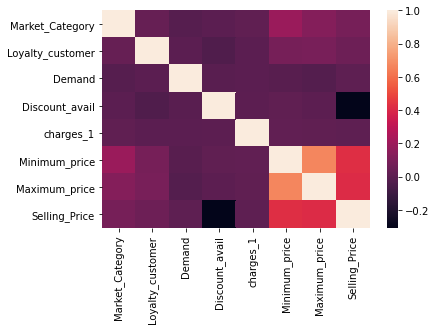

In [118]:
sns.heatmap(data.corr())

In [54]:
data.Stall_no.value_counts()

20.0    227
32.0    224
12.0    221
25.0    218
28.0    215
9.0     214
14.0    214
33.0    210
2.0     208
48.0    207
31.0    206
39.0    205
37.0    204
5.0     202
44.0    202
46.0    202
34.0    201
23.0    201
11.0    200
19.0    199
3.0     198
27.0    197
17.0    197
1.0     197
30.0    196
40.0    196
10.0    193
36.0    193
6.0     190
41.0    190
26.0    189
16.0    189
18.0    188
38.0    188
7.0     187
43.0    187
35.0    187
24.0    186
49.0    186
29.0    185
22.0    182
47.0    182
21.0    181
4.0     181
50.0    180
15.0    180
42.0    180
45.0    180
8.0     179
13.0    168
Name: Stall_no, dtype: int64

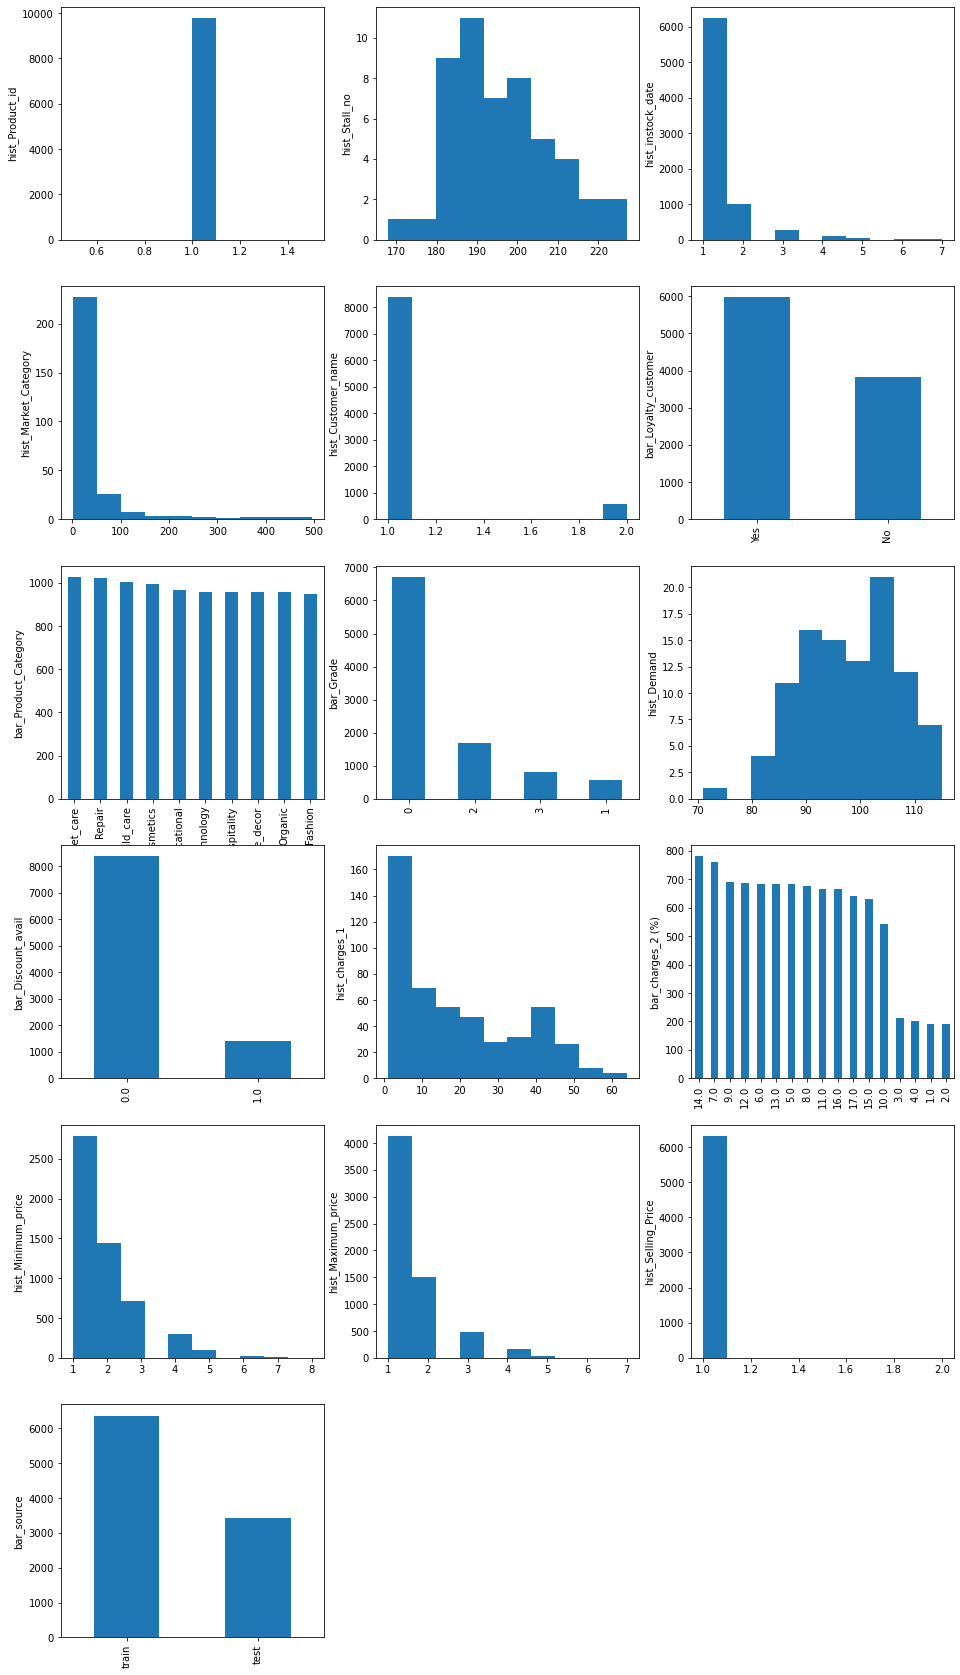

In [49]:
univar_plot()

IndexError: index 10 is out of bounds for axis 0 with size 9

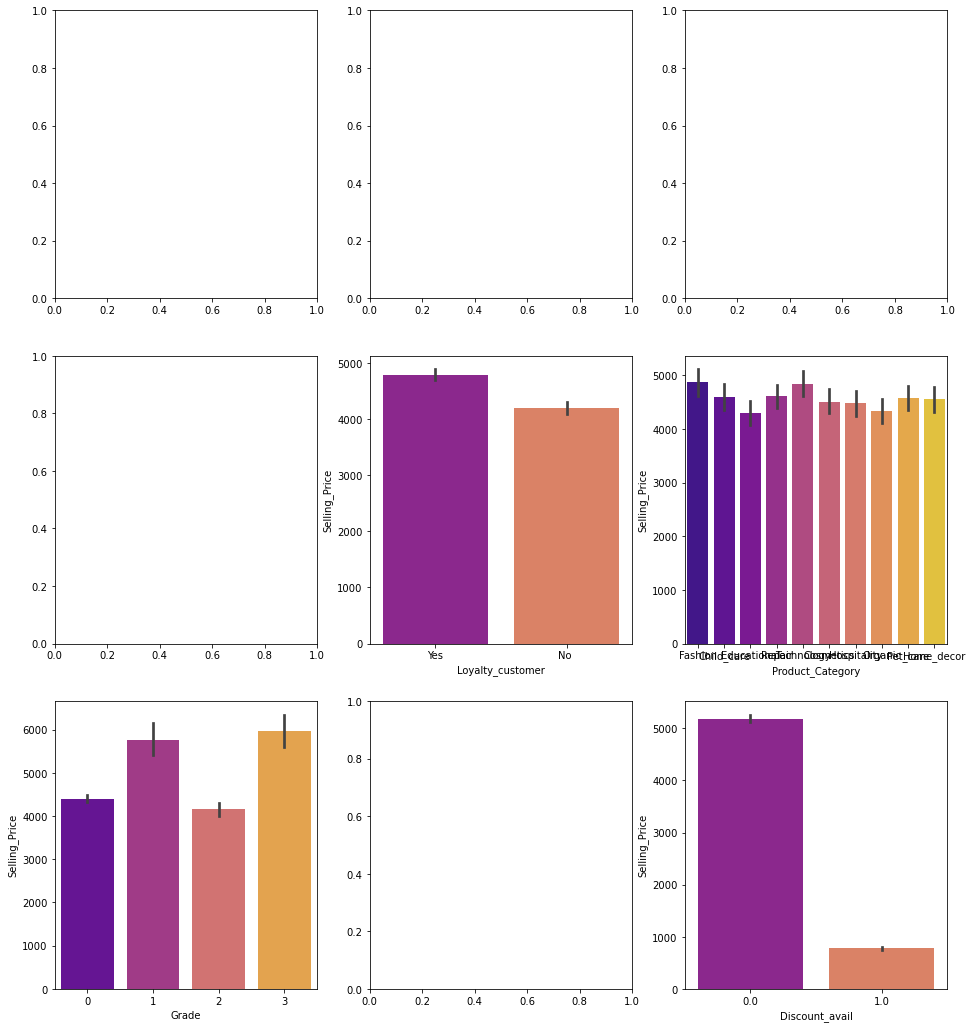

In [59]:
bivar_plot_reg_all_dim_snsbar()

In [63]:
data.head(2)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price,source
0,BRAE2NF6JA5GUEXG,37.0,2015-08-22 18:36:12.000,2,Lillyann,Yes,Fashion,1,68,0.0,376.0,11.0,2983.0,4713.0,4185.947700,train
1,TUNE8SFB6RJN2HSD,38.0,2016-03-27 21:19:13.000,24,Klynn,Yes,Fashion,0,51,0.0,397.0,12.0,7495.0,10352.0,9271.490256,train


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9798 entries, 0 to 9797
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product_id        9798 non-null   object 
 1   Stall_no          9792 non-null   float64
 2   instock_date      9798 non-null   object 
 3   Market_Category   9798 non-null   int64  
 4   Customer_name     9534 non-null   object 
 5   Loyalty_customer  9798 non-null   object 
 6   Product_Category  9798 non-null   object 
 7   Grade             9798 non-null   int64  
 8   Demand            9798 non-null   int64  
 9   Discount_avail    9760 non-null   float64
 10  charges_1         9564 non-null   float64
 11  charges_2 (%)     9588 non-null   float64
 12  Minimum_price     9746 non-null   float64
 13  Maximum_price     9455 non-null   float64
 14  Selling_Price     6327 non-null   float64
 15  source            9798 non-null   object 
dtypes: float64(7), int64(3), object(6)
memory 

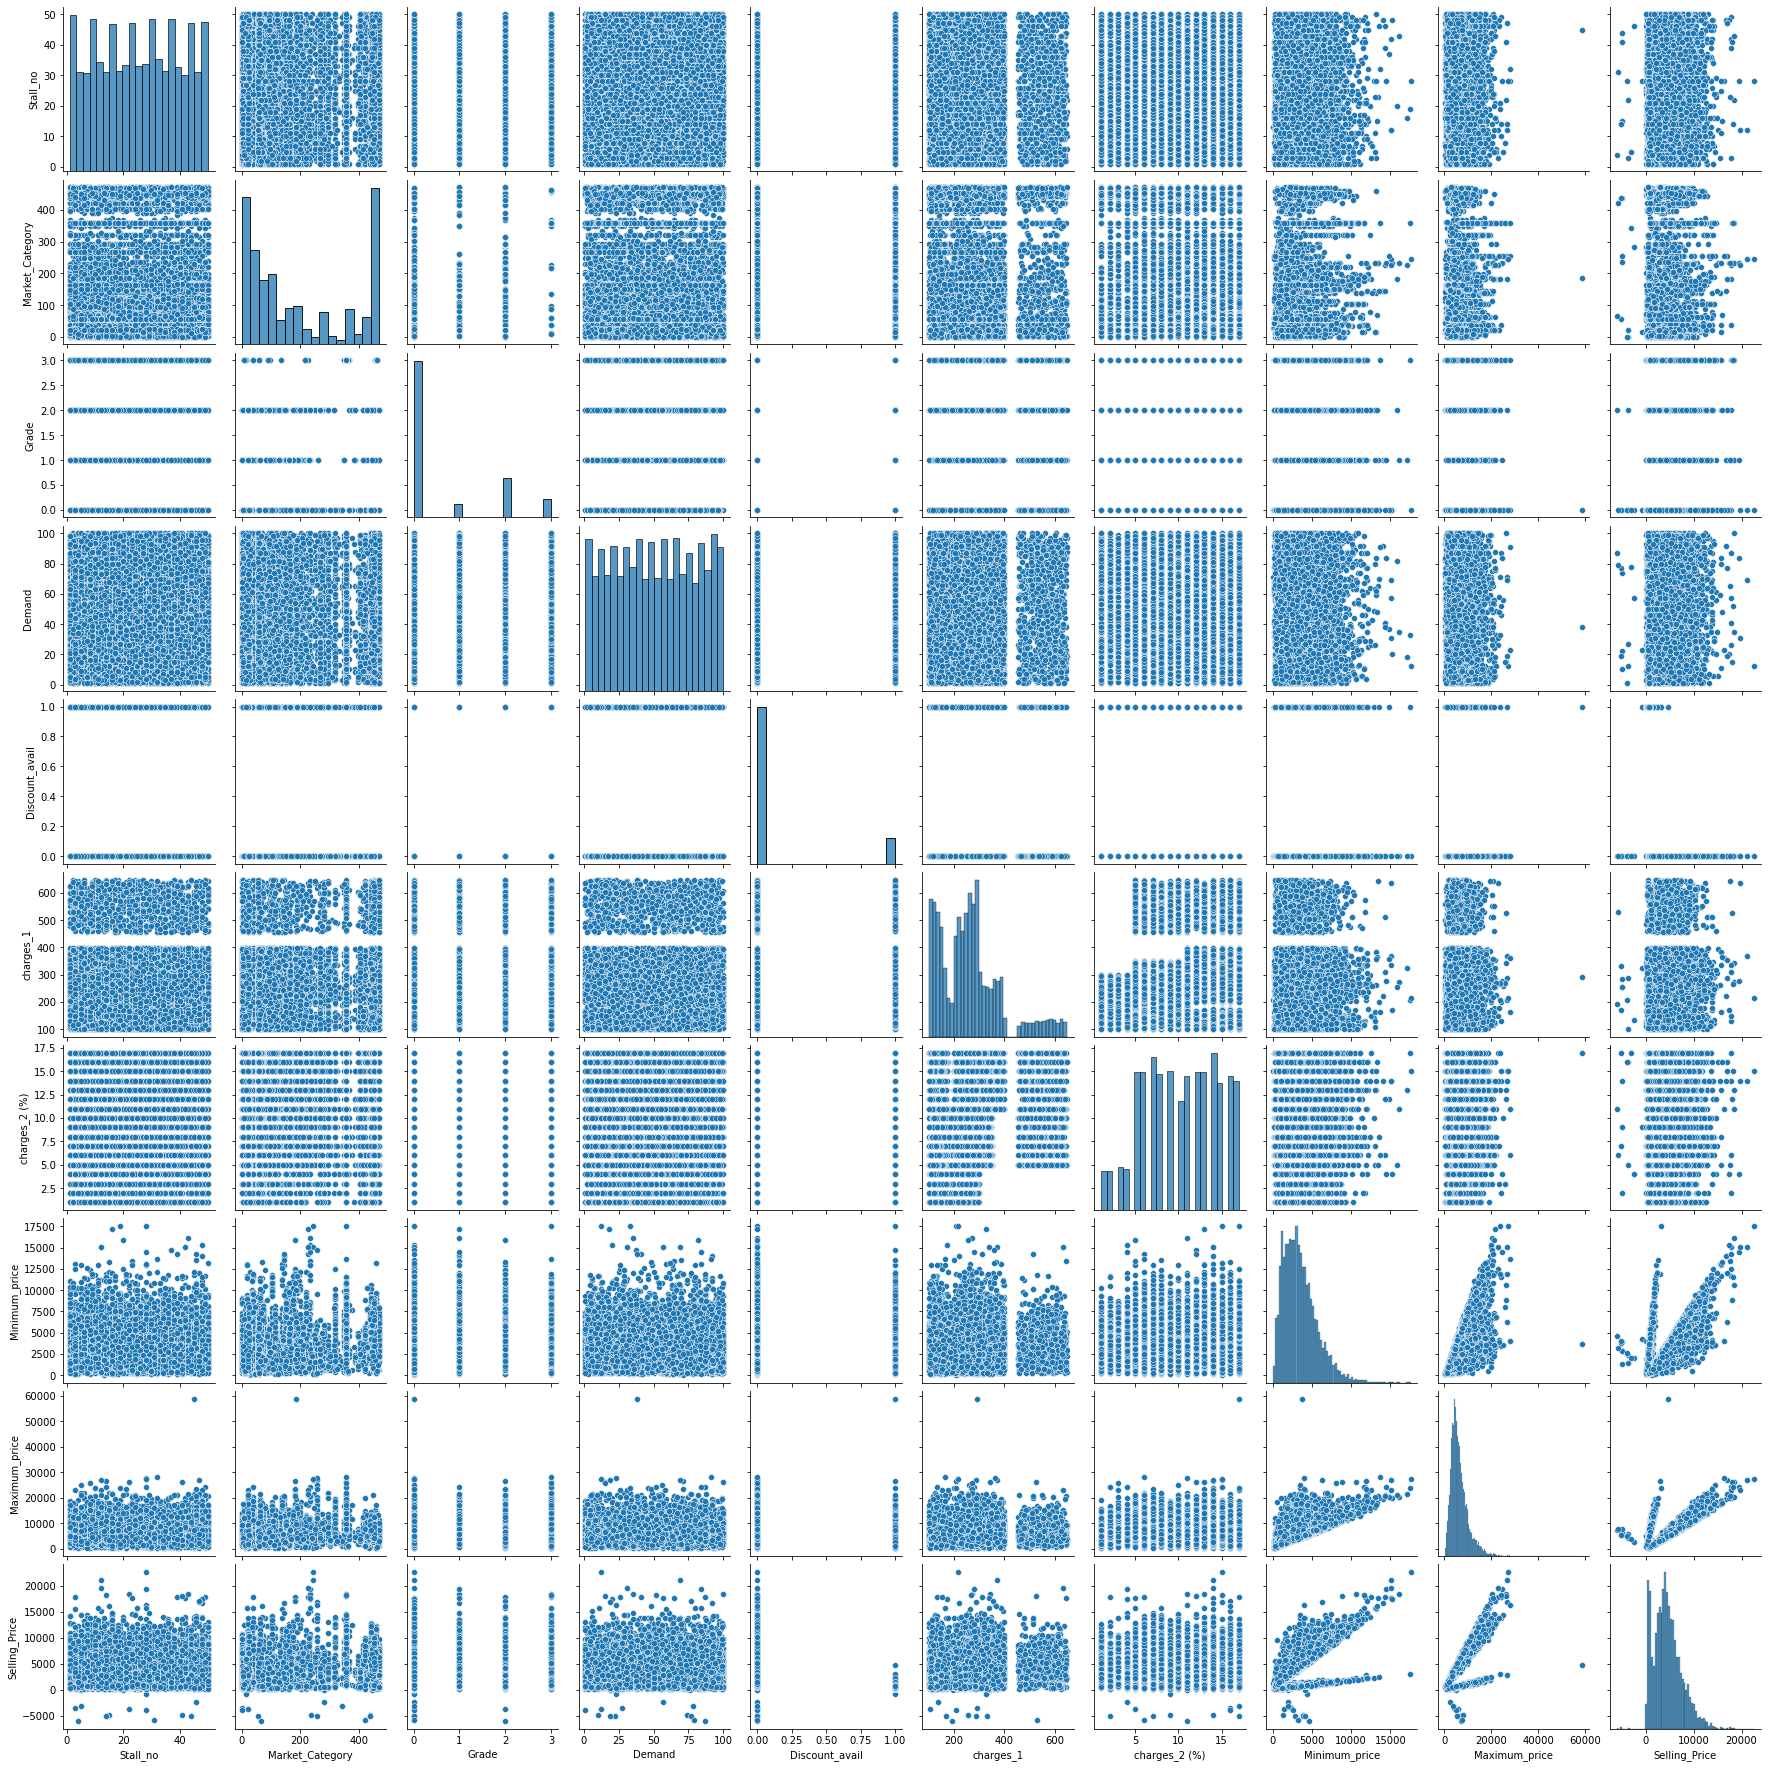

In [60]:
sns.pairplot(data)

In [65]:
display(range_calc(data,['Product_Category','Market_Category','Demand'],['Selling_Price']))

value_count          min  \
Product_Category Market_Category Demand                             
Child_care       0               5                 1  4329.377019   
                                 8                 1          NaN   
                                 13                1          NaN   
                                 27                1 -3584.795550   
                                 43                1  1643.704034   
...                                              ...          ...   
Technology       471             51                1  3245.405616   
                                 69                1          NaN   
                                 77                1          NaN   
                                 91                1          NaN   
                                 96                1          NaN   

                                                 max  count  
Product_Category Market_Category Demand                      
Child_care       0               5       4329.377019      1  
                                 8               NaN      0  
                                 13              NaN      0  
                                 27     -3584.795550      1  
                                 43      1643.704034      1  
...                                              ...    ...  
Technology       471             51      3245.405616      1  
                                 69              NaN      0  
                                 77              NaN      0  
                                 91              NaN      0  
                                 96              NaN      0  

[8963 rows x 4 columns]

#### Data Preprocessing

In [66]:
data.head()

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price,source
0,BRAE2NF6JA5GUEXG,37.0,2015-08-22 18:36:12.000,2,Lillyann,Yes,Fashion,1,68,0.0,376.0,11.0,2983.0,4713.0,4185.947700,train
1,TUNE8SFB6RJN2HSD,38.0,2016-03-27 21:19:13.000,24,Klynn,Yes,Fashion,0,51,0.0,397.0,12.0,7495.0,10352.0,9271.490256,train
2,BRAEAR7WZPQGPBZU,9.0,2015-08-18 19:25:22.000,447,Ridge,Yes,Child_care,0,10,0.0,250.0,9.0,5752.0,7309.0,6785.701362,train
3,WATDZ2ZQ8JPDHCTJ,50.0,2016-03-28 21:53:01.000,23,Abran,Yes,Educational,2,48,0.0,144.0,13.0,5090.0,20814.0,13028.917824,train
4,JWSEBUKYQPMBZ3RK,7.0,2016-03-29 22:58:53.000,63,Dustyn,Yes,Repair,1,35,1.0,211.0,4.0,2430.0,9261.0,906.553935,train


In [79]:
display(data[data['Stall_no'].isna()][['Product_Category','Market_Category']])
x1=range_calc(data,['Product_Category','Market_Category'],['Stall_no'])
x1.to_csv('ws1.csv')
display(x1)

,Product_Category,Market_Category
557,Fashion,151
2825,Hospitality,469
3034,Repair,469
4622,Home_decor,24
4625,Organic,458
7475,Fashion,320


value_count   min   max  count
Product_Category Market_Category                                
Child_care       0                          8   3.0  49.0      8
                 1                         10   1.0  43.0     10
                 2                          3  16.0  46.0      3
                 3                         35   3.0  50.0     35
                 6                          1  21.0  21.0      1
...                                       ...   ...   ...    ...
Technology       460                        2  18.0  29.0      2
                 462                        1  14.0  14.0      1
                 463                        1  33.0  33.0      1
                 469                       22   3.0  49.0     22
                 471                       10   2.0  47.0     10

[1570 rows x 4 columns]

In [82]:
null_percent(data)

for all features
6 ( 0.06 %)--> Stall_no
264 ( 2.69 %)--> Customer_name
38 ( 0.39 %)--> Discount_avail
234 ( 2.39 %)--> charges_1
210 ( 2.14 %)--> charges_2 (%)
52 ( 0.53 %)--> Minimum_price
343 ( 3.5 %)--> Maximum_price
3471 ( 35.43 %)--> Selling_Price


In [84]:
data['Stall_no'] = data['Stall_no'].fillna(0)
data['Customer_name'] = data['Customer_name'].fillna("")
data['Discount_avail'] = data['Discount_avail'].fillna(0)
data['charges_1'] = data['charges_1'].fillna(0)
data['charges_2 (%)'] = data['charges_2 (%)'].fillna(0)
data['Minimum_price'] = data['Minimum_price'].fillna(0)
data['Maximum_price'] = data['Maximum_price'].fillna(0)
data['Selling_Price'] = data['Selling_Price'].fillna(0)
null_percent(data)

for all features


In [85]:
data.head()

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price,source
0,BRAE2NF6JA5GUEXG,37.0,2015-08-22 18:36:12.000,2,Lillyann,Yes,Fashion,1,68,0.0,376.0,11.0,2983.0,4713.0,4185.947700,train
1,TUNE8SFB6RJN2HSD,38.0,2016-03-27 21:19:13.000,24,Klynn,Yes,Fashion,0,51,0.0,397.0,12.0,7495.0,10352.0,9271.490256,train
2,BRAEAR7WZPQGPBZU,9.0,2015-08-18 19:25:22.000,447,Ridge,Yes,Child_care,0,10,0.0,250.0,9.0,5752.0,7309.0,6785.701362,train
3,WATDZ2ZQ8JPDHCTJ,50.0,2016-03-28 21:53:01.000,23,Abran,Yes,Educational,2,48,0.0,144.0,13.0,5090.0,20814.0,13028.917824,train
4,JWSEBUKYQPMBZ3RK,7.0,2016-03-29 22:58:53.000,63,Dustyn,Yes,Repair,1,35,1.0,211.0,4.0,2430.0,9261.0,906.553935,train


In [86]:
data["Loyalty_customer"] = np.where(data["Loyalty_customer"]=="Yes",1,0)

In [87]:
data['Stall_no'] = data['Stall_no'].astype('O')
data['Grade'] = data['Grade'].astype('O')
data['charges_2 (%)'] = data['charges_2 (%)'].astype('O')

#To convert to string for ohe
#Stall_no
#Grade
#charges_2 (%)

#To convert to ohe
#Stall_no
#Product_Category
#Grade
#charges_2 (%)

In [91]:
display(data.select_dtypes(include = np.number).head(1))
numeric_data_columns = data.select_dtypes(include = np.number).drop(columns = [tgt_var]).columns
display(numeric_data_columns)
display(data[numeric_data_columns].head(2))

,Market_Category,Loyalty_customer,Demand,Discount_avail,charges_1,Minimum_price,Maximum_price,Selling_Price
0,2,1,68,0.0,376.0,2983.0,4713.0,4185.9477


Index(['Market_Category', 'Loyalty_customer', 'Demand', 'Discount_avail',
       'charges_1', 'Minimum_price', 'Maximum_price'],
      dtype='object')

,Market_Category,Loyalty_customer,Demand,Discount_avail,charges_1,Minimum_price,Maximum_price
0,2,1,68,0.0,376.0,2983.0,4713.0
1,24,1,51,0.0,397.0,7495.0,10352.0


In [93]:
display(data.select_dtypes(exclude = np.number).head(1))
category_data_columns = data.select_dtypes(exclude = np.number).drop(columns=['Product_id','instock_date','Customer_name',"source"]).columns
display(category_data_columns)
display(data[category_data_columns].head(2))

,Product_id,Stall_no,instock_date,Customer_name,Product_Category,Grade,charges_2 (%),source
0,BRAE2NF6JA5GUEXG,37,2015-08-22 18:36:12.000,Lillyann,Fashion,1,11,train


Index(['Stall_no', 'Product_Category', 'Grade', 'charges_2 (%)'], dtype='object')

,Stall_no,Product_Category,Grade,charges_2 (%)
0,37,Fashion,1,11
1,38,Fashion,0,12


In [96]:
preprocess_cat_data_columns = pd.get_dummies(data[category_data_columns])
display(preprocess_cat_data_columns.head())

,Stall_no_0.0,Stall_no_1.0,Stall_no_2.0,Stall_no_3.0,Stall_no_4.0,Stall_no_5.0,Stall_no_6.0,Stall_no_7.0,Stall_no_8.0,Stall_no_9.0,...,charges_2 (%)_8.0,charges_2 (%)_9.0,charges_2 (%)_10.0,charges_2 (%)_11.0,charges_2 (%)_12.0,charges_2 (%)_13.0,charges_2 (%)_14.0,charges_2 (%)_15.0,charges_2 (%)_16.0,charges_2 (%)_17.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
scaler = MinMaxScaler()
preprocess_numeric_data_columns = pd.DataFrame(scaler.fit_transform(data[numeric_data_columns]), columns=numeric_data_columns)
display(preprocess_numeric_data_columns.head(2))

,Market_Category,Loyalty_customer,Demand,Discount_avail,charges_1,Minimum_price,Maximum_price
0,0.004246,1.0,0.676768,0.0,0.579353,0.169681,0.080137
1,0.050955,1.0,0.505051,0.0,0.611710,0.426337,0.176018


In [99]:
print(preprocess_cat_data_columns.shape, preprocess_numeric_data_columns.shape, data.shape)
print(preprocess_cat_data_columns.index, preprocess_numeric_data_columns.index, data.index)

(9798, 83) (9798, 7) (9798, 16)
RangeIndex(start=0, stop=9798, step=1) RangeIndex(start=0, stop=9798, step=1) RangeIndex(start=0, stop=9798, step=1)


In [101]:
final_preprocessed = pd.concat([preprocess_cat_data_columns, preprocess_numeric_data_columns, data[["Product_id","Selling_Price", "source"]]], axis = 1)
print(final_preprocessed.shape, final_preprocessed.index)
display(final_preprocessed.head(2))

(9798, 93) RangeIndex(start=0, stop=9798, step=1)


,Stall_no_0.0,Stall_no_1.0,Stall_no_2.0,Stall_no_3.0,Stall_no_4.0,Stall_no_5.0,Stall_no_6.0,Stall_no_7.0,Stall_no_8.0,Stall_no_9.0,...,Market_Category,Loyalty_customer,Demand,Discount_avail,charges_1,Minimum_price,Maximum_price,Product_id,Selling_Price,source
0,0,0,0,0,0,0,0,0,0,0,...,0.004246,1.0,0.676768,0.0,0.579353,0.169681,0.080137,BRAE2NF6JA5GUEXG,4185.947700,train
1,0,0,0,0,0,0,0,0,0,0,...,0.050955,1.0,0.505051,0.0,0.611710,0.426337,0.176018,TUNE8SFB6RJN2HSD,9271.490256,train


In [103]:
#combinfo(final_preprocessed)
# throwing error

In [104]:
train_preprocessed = final_preprocessed[final_preprocessed["source"]=="train"]
test_preprocessed = final_preprocessed[final_preprocessed["source"]=="test"]
train_preprocessed = train_preprocessed.drop(columns = ["source"])
test_preprocessed = test_preprocessed.drop(columns = ["source"])
train_preprocessed = train_preprocessed.reset_index().drop(columns='index')
test_preprocessed = test_preprocessed.reset_index().drop(columns='index')
print(train_preprocessed.shape, test_preprocessed.shape)
print(train_preprocessed.index, test_preprocessed.index)

(6368, 92) (3430, 92)
RangeIndex(start=0, stop=6368, step=1) RangeIndex(start=0, stop=3430, step=1)


In [267]:
mlflow.end_run()
logging = True
displaying = True

train_preprocessed = pd.DataFrame() 
test_preprocessed = pd.DataFrame()
data_preprc()

X = train_preprocessed.drop(columns=["Product_id","Selling_Price"])
y = train_preprocessed[["Selling_Price"]]
#display(X.head(2),y.head(2))

alpha_range = [1000, 100, 10, 1, .1, .01, .001, .0001]#[1,0.1] #[10, 1, .1, .01] #
model_keyval = []
n_alpha = 0
model_num = 0
l1_ratio = 0
n_knn = 0

all_models = ["LinearRegression", "Ridge",    "Lasso","ElasticNet","KNeighborsRegressor"]
for i_model in tqdm(all_models) :
    model_num = all_models.index(i_model)+1
    model_keyval.append(all_models.index(i_model)+1)
    if i_model == "LinearRegression" : 
        model = LinearRegression()
        build_model(model,X,y, "Train", "regression", displaying, logging, model_num, n_alpha, l1_ratio, n_knn)
    if i_model == "Ridge" :
        for n_alpha in tqdm(alpha_range) :
            model = Ridge(alpha = n_alpha)
            build_model(model,X,y, "Train", "regression", displaying, logging, model_num, n_alpha, l1_ratio, n_knn)
    if i_model == "Lasso" :
        for n_alpha in tqdm(alpha_range) :
            model = Lasso(alpha = n_alpha)
            build_model(model,X,y, "Train", "regression", displaying, logging, model_num, n_alpha, l1_ratio, n_knn)
    if i_model == "ElasticNet" :
        for n_alpha in tqdm(alpha_range) :
            for l1_ratio in np.arange(0.0, 1.1, 0.1) : 
                model = ElasticNet(alpha = n_alpha, l1_ratio = l1_ratio)
                build_model(model,X,y, "Train", "regression", displaying, logging, model_num, n_alpha, l1_ratio, n_knn)    
    if i_model == "KNeighborsRegressor" :
        for n_knn in tqdm(range(1,11)) :
            model = KNeighborsRegressor(n_neighbors = n_knn)
            build_model(model,X,y, "Train", "regression", displaying, logging, model_num, n_alpha, l1_ratio, n_knn)   

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

INFO: 'he_halloweenSellPrice_training_exp' does not exist. Creating a new experiment
LinearRegression() <class 'sklearn.linear_model._base.LinearRegression'>
LinearRegression
mean Selling_Price    0.028553
dtype: float64
os2: 0
Model : LinearRegression()
Train MSE  score : 799041.810318212
Train RMSE score : 893.8913861975693
Train MAE  score : 475.33142208790593
Train RMSLE score : 6.7955842758437415
LinearRegression
Train MAPE score : 47.40627879319493
Train R2   score : 0.9084541139761777
Train Other score: 0
os3: 0


 12%|██████████▌                                                                         | 1/8 [00:00<00:01,  5.48it/s]

Ridge(alpha=1000) <class 'sklearn.linear_model._ridge.Ridge'>
Ridge
mean Selling_Price    0.11308
dtype: float64
os2: 0
Model : Ridge(alpha=1000)
Train MSE  score : 5932024.658281389
Train RMSE score : 2435.5748106517667
Train MAE  score : 1892.5068284442136
Train RMSLE score : 7.79793806952778
Ridge
Train MAPE score : 98.27645274094809
Train R2   score : 0.32037041585938364
Train Other score: 0
os3: 0
Ridge(alpha=100) <class 'sklearn.linear_model._ridge.Ridge'>
Ridge



 25%|█████████████████████                                                               | 2/8 [00:00<00:01,  5.36it/s]

mean Selling_Price    0.052199
dtype: float64
os2: 0
Model : Ridge(alpha=100)
Train MSE  score : 2404900.8327672677
Train RMSE score : 1550.774268798418
Train MAE  score : 1145.9822547345148
Train RMSLE score : 7.34650961344763
Ridge
Train MAPE score : 46.12989263018439
Train R2   score : 0.7244715173947766
Train Other score: 0
os3: 0
Ridge(alpha=10)


 38%|███████████████████████████████▌                                                    | 3/8 [00:00<00:00,  5.14it/s]

 <class 'sklearn.linear_model._ridge.Ridge'>
Ridge
mean Selling_Price    0.035408
dtype: float64
os2: 0
Model : Ridge(alpha=10)
Train MSE  score : 978886.601292197
Train RMSE score : 989.3869825766847
Train MAE  score : 665.6353536511562
Train RMSLE score : 6.897085541820745
Ridge
Train MAPE score : 48.43996395658824
Train R2   score : 0.887849371491018
Train Other score: 0
os3: 0



 50%|██████████████████████████████████████████                                          | 4/8 [00:00<00:00,  5.04it/s]

Ridge(alpha=1) <class 'sklearn.linear_model._ridge.Ridge'>
Ridge
mean Selling_Price    0.031429
dtype: float64
os2: 0
Model : Ridge(alpha=1)
Train MSE  score : 804184.7567540737
Train RMSE score : 896.7634898645649
Train MAE  score : 502.3234859810334
Train RMSLE score : 6.798792159359815
Ridge
Train MAPE score : 47.62050581524232
Train R2   score : 0.9078648887539624
Train Other score: 0
os3: 0
Ridge(alpha=0.1)


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:01<00:00,  4.83it/s]

 <class 'sklearn.linear_model._ridge.Ridge'>
Ridge
mean Selling_Price    0.028498
dtype: float64
os2: 0
Model : Ridge(alpha=0.1)
Train MSE  score : 799013.2132899817
Train RMSE score : 893.8753902474224
Train MAE  score : 478.11775519071347
Train RMSLE score : 6.795566380947878
Ridge
Train MAPE score : 47.4408562986424
Train R2   score : 0.9084573903257418
Train Other score: 0
os3: 0



 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:01<00:00,  4.75it/s]

Ridge(alpha=0.01) <class 'sklearn.linear_model._ridge.Ridge'>
Ridge
mean Selling_Price    0.028749
dtype: float64
os2: 0
Model : Ridge(alpha=0.01)
Train MSE  score : 798952.3531137998
Train RMSE score : 893.8413467242382
Train MAE  score : 475.63100976547906
Train RMSLE score : 6.795528294910549
Ridge
Train MAPE score : 47.42269855623596
Train R2   score : 0.9084643630506734
Train Other score: 0
os3: 0
Ridge(alpha=0.001)


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:01<00:00,  4.80it/s]

 <class 'sklearn.linear_model._ridge.Ridge'>
Ridge
mean Selling_Price    0.028731
dtype: float64
os2: 0
Model : Ridge(alpha=0.001)
Train MSE  score : 798951.7339751066
Train RMSE score : 893.8410003882718
Train MAE  score : 475.3822430298852
Train RMSLE score : 6.795527907441302
Ridge
Train MAPE score : 47.42089292442089
Train R2   score : 0.9084644339851344
Train Other score: 0
os3: 0
Ridge(alpha=0.0001) <class 'sklearn.linear_model._ridge.Ridge'>
Ridge



  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

mean Selling_Price    0.02873
dtype: float64
os2: 0
Model : Ridge(alpha=0.0001)
Train MSE  score : 798951.7277730247
Train RMSE score : 893.8409969189289
Train MAE  score : 475.3573690248632
Train RMSLE score : 6.795527903559915
Ridge
Train MAPE score : 47.42071254564193
Train R2   score : 0.9084644346957045
Train Other score: 0
os3: 0
Lasso(alpha=1000) 


 12%|██████████▌                                                                         | 1/8 [00:00<00:01,  4.80it/s]

<class 'sklearn.linear_model._coordinate_descent.Lasso'>
Lasso
Model : Lasso(alpha=1000)
Train MSE  score : 8728320.244890993
Train RMSE score : 2954.373071379272
Train MAE  score : 2303.375589275759
Train RMSLE score : 7.991041748745688
Lasso



 25%|█████████████████████                                                               | 2/8 [00:00<00:01,  4.67it/s]

Lasso(alpha=100) <class 'sklearn.linear_model._coordinate_descent.Lasso'>
Lasso
Model : Lasso(alpha=100)
Train MSE  score : 2690293.3518804708
Train RMSE score : 1640.2113741467808
Train MAE  score : 1190.6826706324694
Train RMSLE score : 7.402580399187936
Lasso



 38%|███████████████████████████████▌                                                    | 3/8 [00:00<00:01,  4.51it/s]

Lasso(alpha=10) <class 'sklearn.linear_model._coordinate_descent.Lasso'>
Lasso
Model : Lasso(alpha=10)
Train MSE  score : 831378.4564556942
Train RMSE score : 911.799570330944
Train MAE  score : 555.5076589688879
Train RMSLE score : 6.815420196547539
Lasso



 50%|██████████████████████████████████████████                                          | 4/8 [00:00<00:00,  4.46it/s]

Lasso(alpha=1) <class 'sklearn.linear_model._coordinate_descent.Lasso'>
Lasso
Model : Lasso(alpha=1)
Train MSE  score : 799440.7178830592
Train RMSE score : 894.1144881294896
Train MAE  score : 482.9427841498366
Train RMSLE score : 6.795833829758839
Lasso



 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:01<00:00,  4.40it/s]

Lasso(alpha=0.1) <class 'sklearn.linear_model._coordinate_descent.Lasso'>
Lasso
Model : Lasso(alpha=0.1)
Train MSE  score : 798956.2672101565
Train RMSE score : 893.8435362020339
Train MAE  score : 476.1218322849576
Train RMSLE score : 6.795530744422559
Lasso



 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:01<00:00,  4.44it/s]

Lasso(alpha=0.01) <class 'sklearn.linear_model._coordinate_descent.Lasso'>
Lasso
Model : Lasso(alpha=0.01)
Train MSE  score : 798951.7735426149
Train RMSE score : 893.8410225216869
Train MAE  score : 475.431145895958
Train RMSLE score : 6.7955279322034405
Lasso



 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:01<00:00,  4.75it/s]

Lasso(alpha=0.001) <class 'sklearn.linear_model._coordinate_descent.Lasso'>
Lasso
Model : Lasso(alpha=0.001)
Train MSE  score : 798951.7281709854
Train RMSE score : 893.8409971415416
Train MAE  score : 475.3622620692269
Train RMSLE score : 6.795527903808967
Lasso
Lasso(alpha=0.0001)


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

 <class 'sklearn.linear_model._coordinate_descent.Lasso'>
Lasso
Model : Lasso(alpha=0.0001)
Train MSE  score : 798951.7277149425
Train RMSE score : 893.8409968864387
Train MAE  score : 475.355370353924
Train RMSLE score : 6.795527903523566
Lasso
ElasticNet(alpha=1000, l1_ratio=0.0) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=1000, l1_ratio=0.0)
Train MSE  score : 8727423.744451817
Train RMSE score : 2954.2213431718037
Train MAE  score : 2303.2638780123816
Train RMSLE score : 7.990990390267899
ElasticNet
ElasticNet(alpha=1000, l1_ratio=0.1) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=1000, l1_ratio=0.1)
Train MSE  score : 8727675.557713095
Train RMSE score : 2954.2639620915893
Train MAE  score : 2303.296789482059
Train RMSLE score : 7.991004816611567
ElasticNet
ElasticNet(alpha=1000, l1_ratio=0.2) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : Ela


 12%|██████████▌                                                                         | 1/8 [00:01<00:12,  1.82s/it]

ElasticNet(alpha=1000, l1_ratio=1.0) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=1000, l1_ratio=1.0)
Train MSE  score : 8728320.244890993
Train RMSE score : 2954.373071379272
Train MAE  score : 2303.375589275759
Train RMSLE score : 7.991041748745688
ElasticNet
ElasticNet(alpha=100, l1_ratio=0.0) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=100, l1_ratio=0.0)
Train MSE  score : 8719369.384919813
Train RMSE score : 2952.8578335097363
Train MAE  score : 2302.2596238255605
Train RMSLE score : 7.990528737513466
ElasticNet
ElasticNet(alpha=100, l1_ratio=0.1) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=100, l1_ratio=0.1)
Train MSE  score : 8718764.873955889
Train RMSE score : 2952.755471412404
Train MAE  score : 2302.1872205072737
Train RMSLE score : 7.990494071478946
ElasticNet
ElasticNet(alpha=100, l1_ratio=0.2) <class 'sklearn.line


 25%|█████████████████████                                                               | 2/8 [00:03<00:11,  1.88s/it]

ElasticNet(alpha=10, l1_ratio=0.0) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=10, l1_ratio=0.0)
Train MSE  score : 8640199.540276855
Train RMSE score : 2939.421633634218
Train MAE  score : 2292.350514684957
Train RMSLE score : 7.985968117726503
ElasticNet
ElasticNet(alpha=10, l1_ratio=0.1) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=10, l1_ratio=0.1)
Train MSE  score : 8630976.996656228
Train RMSE score : 2937.8524463723884
Train MAE  score : 2291.1936838529464
Train RMSLE score : 7.985434132998972
ElasticNet
ElasticNet(alpha=10, l1_ratio=0.2) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=10, l1_ratio=0.2)
Train MSE  score : 8619496.809023572
Train RMSE score : 2935.89795616666
Train MAE  score : 2289.751489417509
Train RMSLE score : 7.984768633056374
ElasticNet
ElasticNet(alpha=10, l1_ratio=0.30000000000000004) <class 'sklearn


 38%|███████████████████████████████▌                                                    | 3/8 [00:05<00:09,  1.89s/it]

ElasticNet(alpha=10, l1_ratio=1.0) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=10, l1_ratio=1.0)
Train MSE  score : 831378.4564556942
Train RMSE score : 911.799570330944
Train MAE  score : 555.5076589688879
Train RMSLE score : 6.815420196547539
ElasticNet
ElasticNet(alpha=1, l1_ratio=0.0) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=1, l1_ratio=0.0)
Train MSE  score : 7963825.548776558
Train RMSE score : 2822.0250794024773
Train MAE  score : 2204.1092683992556
Train RMSLE score : 7.9452100194754935
ElasticNet
ElasticNet(alpha=1, l1_ratio=0.1) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=1, l1_ratio=0.1)
Train MSE  score : 7892658.800047699
Train RMSE score : 2809.3876201136254
Train MAE  score : 2194.455942998446
Train RMSLE score : 7.940721809792676
ElasticNet
ElasticNet(alpha=1, l1_ratio=0.2) <class 'sklearn.linear_model._coor


 50%|██████████████████████████████████████████                                          | 4/8 [00:07<00:07,  1.93s/it]

ElasticNet(alpha=1, l1_ratio=1.0) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=1, l1_ratio=1.0)
Train MSE  score : 799440.7178830592
Train RMSE score : 894.1144881294896
Train MAE  score : 482.9427841498366
Train RMSLE score : 6.795833829758839
ElasticNet
ElasticNet(alpha=0.1, l1_ratio=0.0) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=0.1, l1_ratio=0.0)
Train MSE  score : 5231334.7678103205
Train RMSE score : 2287.211133194817
Train MAE  score : 1763.7630092281327
Train RMSLE score : 7.735088508605042
ElasticNet
ElasticNet(alpha=0.1, l1_ratio=0.1) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=0.1, l1_ratio=0.1)
Train MSE  score : 5066086.95820158
Train RMSE score : 2250.7969606789457
Train MAE  score : 1731.7148305933522
Train RMSLE score : 7.719039637228972
ElasticNet
ElasticNet(alpha=0.1, l1_ratio=0.2) <class 'sklearn.linear_mod


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:09<00:05,  1.89s/it]

ElasticNet(alpha=0.1, l1_ratio=1.0) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=0.1, l1_ratio=1.0)
Train MSE  score : 798956.2672101565
Train RMSE score : 893.8435362020339
Train MAE  score : 476.1218322849576
Train RMSLE score : 6.795530744422559
ElasticNet
ElasticNet(alpha=0.01, l1_ratio=0.0) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=0.01, l1_ratio=0.0)
Train MSE  score : 1895175.2845702067
Train RMSE score : 1376.6536545443107
Train MAE  score : 1018.3704057743631
Train RMSLE score : 7.22741094533744
ElasticNet
ElasticNet(alpha=0.01, l1_ratio=0.1) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=0.01, l1_ratio=0.1)
Train MSE  score : 1798394.8216652474
Train RMSE score : 1341.0424384281234
Train MAE  score : 991.3281816474819
Train RMSLE score : 7.2012025296326225
ElasticNet
ElasticNet(alpha=0.01, l1_ratio=0.2) <class 'sklearn


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:11<00:03,  1.94s/it]

ElasticNet(alpha=0.001, l1_ratio=0.0) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=0.001, l1_ratio=0.0)
Train MSE  score : 900730.1337609303
Train RMSE score : 949.0680343162603
Train MAE  score : 612.1126213589655
Train RMSLE score : 6.855480486573751
ElasticNet
ElasticNet(alpha=0.001, l1_ratio=0.1) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=0.001, l1_ratio=0.1)
Train MSE  score : 887334.8931411024
Train RMSE score : 941.9845503728299
Train MAE  score : 601.5226307585232
Train RMSLE score : 6.847988873563767
ElasticNet
ElasticNet(alpha=0.001, l1_ratio=0.2) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=0.001, l1_ratio=0.2)
Train MSE  score : 874077.1747667843
Train RMSE score : 934.9209457311267
Train MAE  score : 590.4049307267627
Train RMSLE score : 6.840461975693947
ElasticNet
ElasticNet(alpha=0.001, l1_ratio=0.30000000000000


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:14<00:02,  2.19s/it]


ElasticNet(alpha=0.0001, l1_ratio=0.0) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=0.0001, l1_ratio=0.0)
Train MSE  score : 801175.6481863366
Train RMSE score : 895.0841570413012
Train MAE  score : 492.59517347293246
Train RMSLE score : 6.796917744068036
ElasticNet
ElasticNet(alpha=0.0001, l1_ratio=0.1) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=0.0001, l1_ratio=0.1)
Train MSE  score : 800773.495941758
Train RMSE score : 894.8594839089309
Train MAE  score : 490.9018919819107
Train RMSLE score : 6.796666704729803
ElasticNet
ElasticNet(alpha=0.0001, l1_ratio=0.2) <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet
Model : ElasticNet(alpha=0.0001, l1_ratio=0.2)
Train MSE  score : 800407.5601902467
Train RMSE score : 894.6549950624803
Train MAE  score : 489.1984382105464
Train RMSLE score : 6.796438163581079
ElasticNet
ElasticNet(alpha=0.0001, l1_ratio=0.300000


 10%|████████▎                                                                          | 1/10 [00:00<00:07,  1.26it/s]

KNeighborsRegressor(n_neighbors=1) <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
KNeighborsRegressor
mean Selling_Price    0.0
dtype: float64
os2: 0
Model : KNeighborsRegressor(n_neighbors=1)
Train MSE  score : 0.0
Train RMSE score : 0.0
Train MAE  score : 0.0
Train RMSLE score : -inf
KNeighborsRegressor
Train MAPE score : 0.0
Train R2   score : 1.0
Train Other score: 0
os3: 0



 20%|████████████████▌                                                                  | 2/10 [00:01<00:06,  1.24it/s]

KNeighborsRegressor(n_neighbors=2) <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
KNeighborsRegressor
mean Selling_Price    0.00963
dtype: float64
os2: 0
Model : KNeighborsRegressor(n_neighbors=2)
Train MSE  score : 1125307.4261392015
Train RMSE score : 1060.8050839523733
Train MAE  score : 743.9784348416641
Train RMSLE score : 6.966783411984568
KNeighborsRegressor
Train MAPE score : 22.701104546634664
Train R2   score : 0.871073998826076
Train Other score: 0
os3: 0



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:05,  1.22it/s]

KNeighborsRegressor(n_neighbors=3) <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
KNeighborsRegressor
mean Selling_Price    0.016412
dtype: float64
os2: 0
Model : KNeighborsRegressor(n_neighbors=3)
Train MSE  score : 1685609.4085693655
Train RMSE score : 1298.3102127647944
Train MAE  score : 913.8846465605312
Train RMSLE score : 7.1688188615948345
KNeighborsRegressor
Train MAPE score : 29.189144559881715
Train R2   score : 0.8068804350349067
Train Other score: 0
os3: 0



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:04,  1.21it/s]

KNeighborsRegressor(n_neighbors=4) <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
KNeighborsRegressor
mean Selling_Price    0.022495
dtype: float64
os2: 0
Model : KNeighborsRegressor(n_neighbors=4)
Train MSE  score : 2161479.004151465
Train RMSE score : 1470.1969269970145
Train MAE  score : 1029.0523331599518
Train RMSLE score : 7.293151634743961
KNeighborsRegressor
Train MAPE score : 34.568645736822155
Train R2   score : 0.752360254492649
Train Other score: 0
os3: 0



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.20it/s]

KNeighborsRegressor() <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
KNeighborsRegressor
mean Selling_Price    0.02771
dtype: float64
os2: 0
Model : KNeighborsRegressor()
Train MSE  score : 2518419.466136104
Train RMSE score : 1586.9528871822579
Train MAE  score : 1109.1975714187708
Train RMSLE score : 7.369571033370097
KNeighborsRegressor
Train MAPE score : 38.28065951103775
Train R2   score : 0.7114657350467604
Train Other score: 0
os3: 0



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.18it/s]

KNeighborsRegressor(n_neighbors=6) <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
KNeighborsRegressor
mean Selling_Price    0.032223
dtype: float64
os2: 0
Model : KNeighborsRegressor(n_neighbors=6)
Train MSE  score : 2766051.933327854
Train RMSE score : 1663.145193098863
Train MAE  score : 1167.1430294466063
Train RMSLE score : 7.41646578331859
KNeighborsRegressor
Train MAPE score : 41.3898978278023
Train R2   score : 0.6830945868482625
Train Other score: 0
os3: 0



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:05<00:02,  1.18it/s]

KNeighborsRegressor(n_neighbors=7) <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
KNeighborsRegressor
mean Selling_Price    0.037086
dtype: float64
os2: 0
Model : KNeighborsRegressor(n_neighbors=7)
Train MSE  score : 3014910.879130901
Train RMSE score : 1736.3498723272626
Train MAE  score : 1224.5997196098776
Train RMSLE score : 7.45954041427299
KNeighborsRegressor
Train MAPE score : 44.31852785500558
Train R2   score : 0.6545829215082204
Train Other score: 0
os3: 0



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:06<00:01,  1.16it/s]

KNeighborsRegressor(n_neighbors=8) <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
KNeighborsRegressor
mean Selling_Price    0.04038
dtype: float64
os2: 0
Model : KNeighborsRegressor(n_neighbors=8)
Train MSE  score : 3239789.1839353754
Train RMSE score : 1799.9414390294412
Train MAE  score : 1271.9779998718468
Train RMSLE score : 7.4955094094824855
KNeighborsRegressor
Train MAPE score : 47.04618418251546
Train R2   score : 0.6288187081779288
Train Other score: 0
os3: 0



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:07<00:00,  1.15it/s]

KNeighborsRegressor(n_neighbors=9) <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
KNeighborsRegressor
mean Selling_Price    0.043738
dtype: float64
os2: 0
Model : KNeighborsRegressor(n_neighbors=9)
Train MSE  score : 3419992.7224289104
Train RMSE score : 1849.322233259772
Train MAE  score : 1309.8339173073448
Train RMSLE score : 7.52257449054588
KNeighborsRegressor
Train MAPE score : 49.56596618636105
Train R2   score : 0.6081728641394938
Train Other score: 0
os3: 0



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.09s/it]

KNeighborsRegressor(n_neighbors=10) <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
KNeighborsRegressor
mean Selling_Price    0.046775
dtype: float64
os2: 0
Model : KNeighborsRegressor(n_neighbors=10)
Train MSE  score : 3583460.621245504
Train RMSE score : 1893.003069528812
Train MAE  score : 1344.7406190640036
Train RMSLE score : 7.545919772723493
KNeighborsRegressor
Train MAPE score : 52.0186344564444
Train R2   score : 0.5894444153394767
Train Other score: 0
os3: 0


In [254]:
train_preprocessed = pd.DataFrame() 
test_preprocessed = pd.DataFrame()
data_preprc()

X = train_preprocessed.drop(columns=["Product_id","Selling_Price"])
y = train_preprocessed[["Selling_Price"]]
display(X.head(2),y.head(2))
null_percent(X)
null_percent(y)

model = LinearRegression()
#y_train_pred = 
build_model(model,X,y, "Train", "regression", displaying, logging, model_num, n_alpha, l1_ratio, n_knn)

test_X = test_preprocessed.drop(columns=["Product_id","Selling_Price"])
y_test_pred = model.predict(test_X)

submission = pd.DataFrame()
submission["Product_id"] = test_preprocessed["Product_id"]
submission["Selling_Price"] = y_test_pred
#submission["price"] = np.round(np.expm1(y_test_pred),2)

print(submission[submission['Selling_Price']<0].head())
submission["Selling_Price"] = abs(y_test_pred)
print(submission[submission['Selling_Price']<0].head())
print(submission.index)
#print(submission)
print(submission["Selling_Price"].max())
#submission.to_csv("test2_drop_linreg_result1.csv", index = False)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price,source
0,BRAE2NF6JA5GUEXG,37.0,2015-08-22 18:36:12.000,2,Lillyann,Yes,Fashion,1,68,0.0,376.0,11.0,2983.0,4713.0,4185.947700,train
1,TUNE8SFB6RJN2HSD,38.0,2016-03-27 21:19:13.000,24,Klynn,Yes,Fashion,0,51,0.0,397.0,12.0,7495.0,10352.0,9271.490256,train


9798 (9798, 16) RangeIndex(start=0, stop=9798, step=1)


,Stall_no,Market_Category,Loyalty_customer,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price
0,37.0,2,1,68,0.0,376.0,11.0,2983.0,4713.0,4185.9477


Index(['Stall_no', 'Market_Category', 'Loyalty_customer', 'Demand',
       'Discount_avail', 'charges_1', 'charges_2 (%)', 'Minimum_price',
       'Maximum_price'],
      dtype='object')

,Stall_no,Market_Category,Loyalty_customer,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price
0,37.0,2,1,68,0.0,376.0,11.0,2983.0,4713.0
1,38.0,24,1,51,0.0,397.0,12.0,7495.0,10352.0


,Product_id,instock_date,Customer_name,Product_Category,Grade,source
0,BRAE2NF6JA5GUEXG,2015-08-22 18:36:12.000,Lillyann,Fashion,1,train


Index(['Product_Category', 'Grade'], dtype='object')

,Product_Category,Grade
0,Fashion,1
1,Fashion,0


,Product_Category_Child_care,Product_Category_Cosmetics,Product_Category_Educational,Product_Category_Fashion,Product_Category_Home_decor,Product_Category_Hospitality,Product_Category_Organic,Product_Category_Pet_care,Product_Category_Repair,Product_Category_Technology,Grade_0,Grade_1,Grade_2,Grade_3
0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1,0,0,1,0,0


,Stall_no,Market_Category,Loyalty_customer,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price
0,0.734694,0.004246,1.0,0.676768,0.0,0.502732,0.6250,0.169634,0.077580
1,0.755102,0.050955,1.0,0.505051,0.0,0.540984,0.6875,0.426304,0.173728


(9798, 14) (9798, 9) (9798, 16)
RangeIndex(start=0, stop=9798, step=1) RangeIndex(start=0, stop=9798, step=1) RangeIndex(start=0, stop=9798, step=1)
(9798, 26) Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9788, 9789, 9790, 9791, 9792, 9793, 9794, 9795, 9796, 9797],
           dtype='int64', length=9798)


,Product_Category_Child_care,Product_Category_Cosmetics,Product_Category_Educational,Product_Category_Fashion,Product_Category_Home_decor,Product_Category_Hospitality,Product_Category_Organic,Product_Category_Pet_care,Product_Category_Repair,Product_Category_Technology,...,Loyalty_customer,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Product_id,Selling_Price,source
0,0,0,0,1,0,0,0,0,0,0,...,1.0,0.676768,0.0,0.502732,0.6250,0.169634,0.077580,BRAE2NF6JA5GUEXG,4185.947700,train
1,0,0,0,1,0,0,0,0,0,0,...,1.0,0.505051,0.0,0.540984,0.6875,0.426304,0.173728,TUNE8SFB6RJN2HSD,9271.490256,train


(6368, 25) (3430, 25)
RangeIndex(start=0, stop=6368, step=1) RangeIndex(start=0, stop=3430, step=1)


,Product_Category_Child_care,Product_Category_Cosmetics,Product_Category_Educational,Product_Category_Fashion,Product_Category_Home_decor,Product_Category_Hospitality,Product_Category_Organic,Product_Category_Pet_care,Product_Category_Repair,Product_Category_Technology,...,Grade_3,Stall_no,Market_Category,Loyalty_customer,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price
0,0,0,0,1,0,0,0,0,0,0,...,0,0.734694,0.004246,1.0,0.676768,0.0,0.502732,0.6250,0.169634,0.077580
1,0,0,0,1,0,0,0,0,0,0,...,0,0.755102,0.050955,1.0,0.505051,0.0,0.540984,0.6875,0.426304,0.173728


,Selling_Price
0,4185.947700
1,9271.490256


for all features
for all features
LinearRegression() <class 'sklearn.linear_model._base.LinearRegression'>
LinearRegression
mean Selling_Price    0.027249
dtype: float64
os2: 0
Model : LinearRegression()
Train MSE  score : 976154.8345157462
Train RMSE score : 988.005483039313
Train MAE  score : 493.3135918778549
Train RMSLE score : 6.895688247367401
LinearRegression
Train MAPE score : 64.91786608126611
Train R2   score : 0.8898640090902575
Train Other score: 0
           Product_id  Selling_Price
32   RNGE88FRGZCXNKUG         -164.0
59   ACCE9EYRRNZYZUBG         -976.0
72   WCKEGGGD2TXHHTJC        -1744.0
94   NKCECKHYZVHBQU9F         -832.0
108  PBXECYF3YHWYG4UN        -2024.0
Empty DataFrame
Columns: [Product_id, Selling_Price]
Index: []
RangeIndex(start=0, stop=3430, step=1)
19076.0


In [184]:
data = data_orig.copy().reset_index().drop(columns="index")

display(data[data['Selling_Price'].isna()]['source'].value_counts())
data = data.drop(data[(data['Selling_Price'].isna()) & (data['source']=='train')].index)
display(data[data['Selling_Price'].isna()]['source'].value_counts())

display(data[data['Selling_Price']<0]['source'].value_counts())
data = data.drop(data[(data['Selling_Price'] < 0)].index)
display(data[data['Selling_Price']<0]['source'].value_counts())

test     3430
train      41
Name: source, dtype: int64

test    3430
Name: source, dtype: int64

train    14
Name: source, dtype: int64

Series([], Name: source, dtype: int64)

In [186]:
display(data[data['Stall_no'].isna()]['source'].value_counts())
#data = data.drop(data[(data['Stall_no'].isna()) & (data['source']=='train')].index)
data['Stall_no'] = data['Stall_no'].fillna(data['Stall_no'].mode()[0])
display(data[data['Stall_no'].isna()]['source'].value_counts())

train    5
test     1
Name: source, dtype: int64

Series([], Name: source, dtype: int64)

In [240]:
data[data['Selling_Price']<0][['Selling_Price']]

,Selling_Price


In [242]:
data = data_orig.copy().reset_index().drop(columns="index")
display(data[data['Selling_Price']<0]['source'].value_counts())
display(data[data['Selling_Price'].isna()]['source'].value_counts())

train    14
Name: source, dtype: int64

test     3430
train      41
Name: source, dtype: int64

In [260]:
def data_preprc():
    data = pd.concat([train,test])
    data_orig = data.copy()
    #display(data.head(2))
    data = data.reset_index().drop(columns="index")
    #print(train.shape[0]+test.shape[0], data.shape, data.index)

    #'''
    data = data.drop(data[(data['Selling_Price'].isna()) & (data['source']=='train')].index)
    data = data.drop(data[(data['Selling_Price'] < 0)].index)
    data = data.reset_index().drop(columns="index")
    data['Stall_no'] = data['Stall_no'].fillna(data['Stall_no'].mode()[0])
    data['Customer_name'] = data['Customer_name'].fillna("")
    data['Discount_avail'] = data['Discount_avail'].fillna(data['Discount_avail'].mean())
    data['charges_1'] = data['charges_1'].fillna(data['charges_1'].mean())
    data['charges_2 (%)'] = data['charges_2 (%)'].fillna(data['charges_2 (%)'].mean())
    data['Minimum_price'] = data['Minimum_price'].fillna(data['Minimum_price'].mean())
    data['Maximum_price'] = data['Maximum_price'].fillna(data['Maximum_price'].mean())    
    #Train RMSLE score : 6.7955842758437415
    #sub: 10.04454   
    #'''
    
    '''
    data['Minimum_price'] = data['Minimum_price'].fillna(data['Minimum_price'].mean())
    data['Maximum_price'] = data['Maximum_price'].fillna(data['Maximum_price'].mean())    
    data['Selling_Price'] = data['Selling_Price'].fillna((data['Minimum_price']+data['Maximum_price'])/2)
    data[data['Selling_Price'] < 0][['Selling_Price']] = ((data['Minimum_price']+data['Maximum_price'])/2)   
    data['Stall_no'] = data['Stall_no'].fillna(data['Stall_no'].mode()[0])
    data['Customer_name'] = data['Customer_name'].fillna("")
    data['Discount_avail'] = data['Discount_avail'].fillna(data['Discount_avail'].mean())
    data['charges_1'] = data['charges_1'].fillna(data['charges_1'].mean())
    data['charges_2 (%)'] = data['charges_2 (%)'].fillna(data['charges_2 (%)'].mean())
    #Train RMSLE score : 6.895688247367401
    '''              
    
    '''
    data['Stall_no'] = data['Stall_no'].fillna(0)
    data['Customer_name'] = data['Customer_name'].fillna("")
    data['Discount_avail'] = data['Discount_avail'].fillna(0)
    data['charges_1'] = data['charges_1'].fillna(0)
    data['charges_2 (%)'] = data['charges_2 (%)'].fillna(0)
    data['Minimum_price'] = data['Minimum_price'].fillna(0)
    data['Maximum_price'] = data['Maximum_price'].fillna(0)
    data['Selling_Price'] = data['Selling_Price'].fillna(0)
    #Train RMSLE score : 7.063956846020314
    #sub: 9.87534
    '''

    data["Loyalty_customer"] = np.where(data["Loyalty_customer"]=="Yes",1,0)

    #data['Stall_no'] = data['Stall_no'].astype('O')
    data['Grade'] = data['Grade'].astype('O')
    #data['charges_2 (%)'] = data['charges_2 (%)'].astype('O')
    
    #display(data.select_dtypes(include = np.number).head(1))
    numeric_data_columns = data.select_dtypes(include = np.number).drop(columns = [tgt_var]).columns
    #display(numeric_data_columns)
    #display(data[numeric_data_columns].head(2))

    #display(data.select_dtypes(exclude = np.number).head(1))
    category_data_columns = data.select_dtypes(exclude = np.number).drop(columns=['Product_id','instock_date','Customer_name',"source"]).columns
    #display(category_data_columns)
    #display(data[category_data_columns].head(2))

    preprocess_cat_data_columns = pd.get_dummies(data[category_data_columns])
    #display(preprocess_cat_data_columns.head())

    scaler = MinMaxScaler()
    preprocess_numeric_data_columns = pd.DataFrame(scaler.fit_transform(data[numeric_data_columns]), columns=numeric_data_columns)
    #display(preprocess_numeric_data_columns.head(2))
   
    #print(preprocess_cat_data_columns.shape, preprocess_numeric_data_columns.shape, data.shape)
    #print(preprocess_cat_data_columns.index, preprocess_numeric_data_columns.index, data.index)

    final_preprocessed = pd.concat([preprocess_cat_data_columns, preprocess_numeric_data_columns, data[["Product_id","Selling_Price", "source"]]], axis = 1)
    #final_preprocessed = final_preprocessed.drop(final_preprocessed[(final_preprocessed.isna())].index)
    final_preprocessed = final_preprocessed.dropna(how='all',axis=0)
    #print(final_preprocessed.shape, final_preprocessed.index)
    #display(final_preprocessed.head(2))
    
    global train_preprocessed 
    global test_preprocessed    
    train_preprocessed = final_preprocessed[final_preprocessed["source"]=="train"]
    test_preprocessed = final_preprocessed[final_preprocessed["source"]=="test"]
    train_preprocessed = train_preprocessed.drop(columns = ["source"])
    test_preprocessed = test_preprocessed.drop(columns = ["source"])
    train_preprocessed = train_preprocessed.reset_index().drop(columns='index')
    test_preprocessed = test_preprocessed.reset_index().drop(columns='index')
    #print(train_preprocessed.shape, test_preprocessed.shape)
    #print(train_preprocessed.index, test_preprocessed.index)

    

In [266]:
tracking_uri = mlflow.get_tracking_uri()
print(tracking_uri)
mlflow.set_tracking_uri("file:///D:/Zia/Datas/inceptez/mltracking/mlflow/notebooks/mlruns")
tracking_uri = mlflow.get_tracking_uri()
print(tracking_uri)

file:///D:/Zia/Datas/inceptez/hackathon-i2/he_halloweenPredSellPrice/mlruns
file:///D:/Zia/Datas/inceptez/mltracking/mlflow/notebooks/mlruns
